In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [2]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

The sarimax model can be defined by:

$\displaystyle y_t = SARIMA(p,d,q)(P,D,Q)_m + \sum_{i=1}^{n}\beta_iX_{t}^{i}$

## forcasting USA real GDP

We'll use a macroeconomics dataset that already comes in statsmodel.

In [3]:
# load the US macroeconomics dataset.
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


We will only use 
- `realgdp`: real gross domestic product (our target variable)
- `realcons`: real personal consumption expenditure
- `realinv`: real gross private domestic investment
- `realgovt`: real federal consumption expenditure and invesment
- `realdpi`: real private disposable income
- `cpi`: consumer price index for the end of the quarter

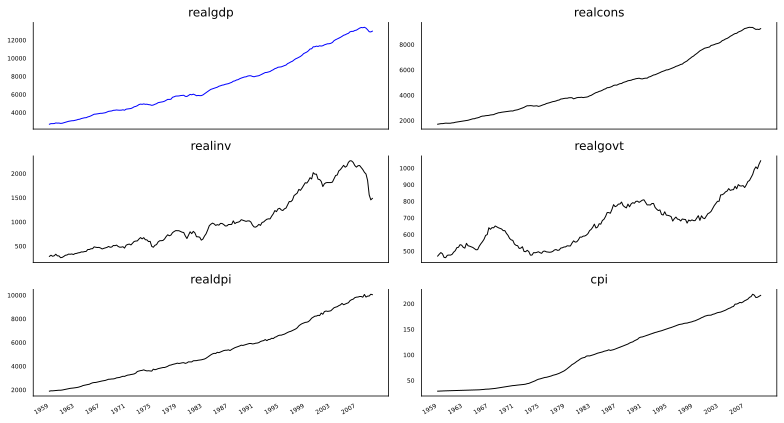

In [4]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (11, 6))

color = 'b'
for i, ax in enumerate(axs.flatten()[:6]):
    # :6 since we only want the first six
    
    # i + 2 since we want to skip year and quarter cols
    data = macro_econ_data[macro_econ_data.columns[i + 2]]
    
    ax.plot(data, color = color, linewidth = 1)
    color = 'k'
    ax.set_title(macro_econ_data.columns[i + 2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.setp(axs, xticks = np.arange(0, 208, 16), xticklabels=np.arange(1959, 2010, 4))

fig.autofmt_xdate()    
plt.tight_layout()

We are trying to predict realgdp, so let's continue as we usually do. Testing for stationarity, buuuut before that, let's decompose the series, because I really like how that looks, and to see for seasonality of course

In [5]:
# the period is equal to the frequency
# STL stands for Season-Trend decomposition using LOESS.
decomposition = sm.tsa.STL(macro_econ_data.realgdp, period = 12).fit()

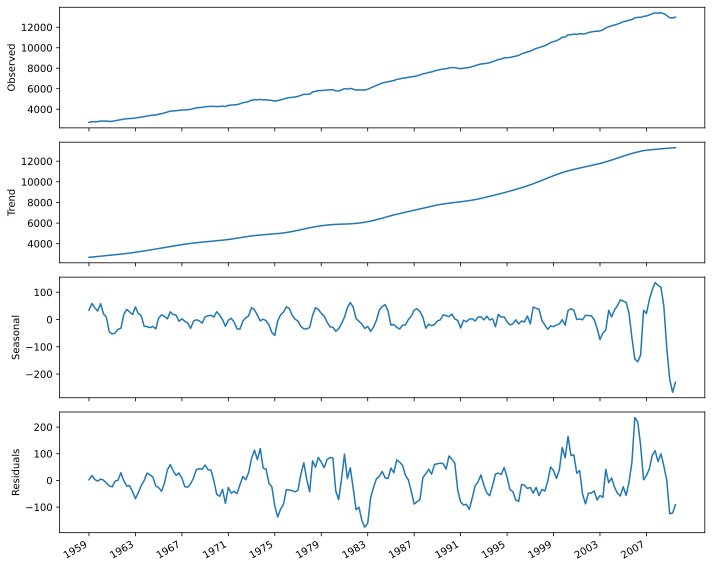

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows = 4, ncols = 1, 
    sharex = True, 
    figsize=(10,8)
) 

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

Okay, it does not look like it has seasonality. Let's test for stationary then

In [7]:
adf = sm.tsa.stattools.adfuller(macro_econ_data.realgdp)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic 1.750462796764714
p-value 0.9982455372335032


In [8]:
diff = np.diff(macro_econ_data.realgdp, n = 1)
adf = sm.tsa.stattools.adfuller(diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -6.305695561658104
p-value 3.327882187668259e-08


So we can now reject the null hypothesis and state that the series is now stationary, we just diff it one time so $d = 1$, since we did not take a seasonal difference to make the series stationary then $D=0$

In [9]:
import tqdm
def optimize_sarimax(
        endog: pd.Series | list, exog: pd.Series | list, order_l: list, 
        d: int, D: int, s:int) -> pd.DataFrame:

    '''
    Given a list of combinations of p,q test different combinations of arma
    orders, and compare them against each other using Akaike Information
    criterion.

    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param order_l list: list of all combinations of p and q
    :param d int: number of times the dataset needs to be diff to become 
                  stationary 

    :returns: dataframe with two columns, one the combination of p and q,
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in tqdm.tqdm_notebook(order_l):
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog,
                exog,
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

In [10]:
ps = range(0, 4) 
qs = range(0, 4)
Ps = range(0, 4)
Qs = range(0, 4)

d = 1
D = 0
s = 4 # since the data is collected quarterly m = s = 4

# list with all combinations posible for p,q,P,Q
order_l = list(itertools.product(ps, qs, Ps, Qs))

In [11]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [12]:
target_train = target[:200]
exog_train = exog[:200]

In [13]:
result_df = optimize_sarimax(target_train, exog_train, order_l, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.844368
1,"(3, 3, 1, 0)",1744.962258
2,"(3, 3, 0, 1)",1744.997864
3,"(2, 2, 0, 0)",1745.456829
4,"(2, 2, 0, 1)",1745.925785
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


We can see that the optimal model is $SARIMA(3,1,3)(0,0,0)_4$; we got nothing from the seasonality part, this makes sense since, there is no visible seasonal pattern in the plot of GDP. So basically we have $ARIMA(3,1,3)$

In [18]:
model = sm.tsa.statespace.SARIMAX(
    target_train,
    exog_train,
    order = (3, 1, 3),
    seasonal_order = (0, 0, 0, 4),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.422
Date:                Sat, 29 Apr 2023   AIC                           1742.844
Time:                        17:43:44   BIC                           1782.364
Sample:                             0   HQIC                          1758.839
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9660      0.045     21.628      0.000       0.878       1.054
realinv        1.0136      0.033     30.866      0.000       0.949       1.078
realgovt       0.7278      0.127      5.736      0.000       0.479       0.977
realdpi        0.0092      0.025      0.371      0.711      -0.039       0.058
cpi            5.8671      1.311      4.474      0.000       3.297       8.437
ar.L1          1.0659      0.395      2.697      0.007       0.291       1.841
ar.L2          0.4905      0.696      0.705      0.481      -0.873       1.854
ar.L3         -0.6738      0.334     -2.016      0.044      -1.329      -0.019
ma.L1         -1.1037      0.427     -2.586      0.010      -1.940      -0.267
ma.L2         -0.3203      0.761     -0.421      0.674      -1.812       1.171
ma.L3          0.6459      0.400      1.614      0.107      -0.138       1.430
sigma2       329.5562     30.487     10.810      0.000     269.803     389.310
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.56   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> you’ll notice that all exogenous variables have a p-value smaller than 0.05, except for realdpi, which has a p-value of 0.712. This means that the coefficient of realdpi is not significantly different from 0. You’ll also notice that its coefficient is 0.0091. **However, the coefficient is kept in the model, as the p-value does not determine the relevance of this predictor in forecasting our target.**

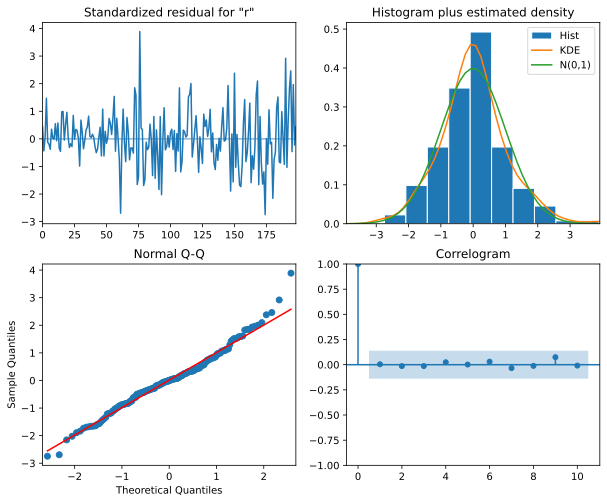

In [22]:
model.plot_diagnostics(figsize = (10, 8))
plt.show()

In [23]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,0.078830,0.778889
2,0.210098,0.900281
3,0.215635,0.975027
4,1.172824,0.882552
5,1.175133,0.947241
6,1.193668,0.977196
7,1.394578,0.985737
8,1.405699,0.994165
9,1.775424,0.994542
10,1.780044,0.997765


In [52]:
import tqdm

def rolling_forecast(endog: pd.DataFrame, exog: pd.DataFrame,
                     train_len: int, horizon: int,
                     window: int, method: str) -> list:
    '''
    given a dataset, forecast using one of two methods:

        1. last value  (last)
        2. SARIMAX(3,1,3)(0,0,0)4 (sarimax)
    
    the training length will be updated with each iteration as if we were
    seeing new observations

    :param pd.DataFrame df: data frame with two columns
    :param int train_len: number of data point that can be used to fit the
                          model
    :param int horizon: length of the test set, how many values we want to
                        predict
    :param int window: how many timesteps are predicted at a time
    :param int method: last | SARIMAX, method used to do the forecast

    :return:
    :rtype: list
    '''

    # train length + the horizon make the total length of the dataset
    # meaning it includes the prediction as well
    total_len = train_len + horizon

    if method.lower() == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    if method.lower() == 'sarimax':
        pred_sarimax = []

        # tqdm part adds a progressbar, really helpful :)
        for i in  tqdm.tqdm_notebook(range(train_len, total_len, window)):
            model = sm.tsa.statespace.SARIMAX(
                endog[:i], exog[:i],
                order = (3, 1, 3), seasonal_order = (0, 0, 0, 4),
                simple_differencing = False,
            )
            r = model.fit(disp = False)
            predictions = r.get_prediction(exog = exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_sarimax.extend(oos_pred)

        return pred_sarimax

    return []

In [53]:
target_train = target[:196]
target_test = target[196:]

In [54]:
pred_df = pd.DataFrame({'actual': target_test})

In [55]:
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

In [58]:
pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_sarimax = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_sarimax'] = pred_sarimax

  0%|          | 0/7 [00:00<?, ?it/s]

In [59]:
pred_df

,actual,pred_last_value,pred_sarimax,pred_SARIMAX
196,13366.865,13391.249,13344.062785,13344.062785
197,13415.266,13366.865,13373.510136,13373.510136
198,13324.600,13415.266,13378.825101,13378.825101
199,13141.920,13324.600,13327.778008,13327.778008
200,12925.410,13141.920,13133.862811,13133.862811
201,12901.504,12925.410,12887.493940,12887.493940
202,12990.341,12901.504,12873.788319,12873.788319


In [60]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
mape_last = mape(pred_df['actual'], pred_df['pred_last_value'])
mape_sarima = mape(pred_df['actual'], pred_df['pred_sarimax'])

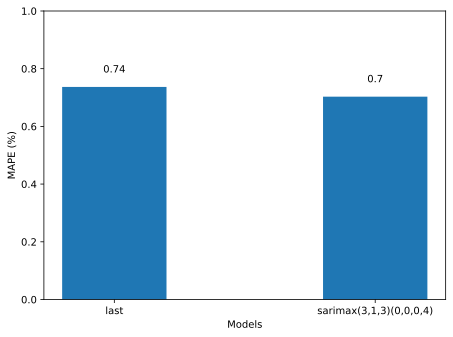

In [67]:
fig, ax = plt.subplots()

x = ['last', 'sarimax(3,1,3)(0,0,0,4)']
y = [mape_last, mape_sarima]


ax.bar(x, y, width = 0.4)

ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(
        x = index, y = value + 0.05, 
        s = str(round(value,2)), ha = 'center'
    )
    
plt.tight_layout()


The error between using sarimax and just using the last value is pretty minimal. Here is where the business question comes into play. Should we waste our time doing this sarimax model? Well in this context, that $0.04$ percent is a lot of money, becuase we are taking about GDP so probably it is